# Models Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# Set paths
model_path = Path("../models")
wells = ['withams', 'greenbush', 'churchneck', 'capecharles']

In [16]:
import pickle
for w in wells:
    full_df = pd.read_csv(model_path / f"HISTORY_{w}.csv")
    full_df['Date'] = pd.to_datetime(full_df['Date'])
    
    mlr = pd.read_csv(model_path / f"PRED_MLR_{w}.csv")
    cnn = pd.read_csv(model_path / f"PRED_CNN_{w}.csv")
    lstm = pd.read_csv(model_path / f"PRED_LSTM_{w}.csv")
    
    for df_model in [mlr, cnn, lstm]:
        df_model['Date'] = pd.to_datetime(df_model['Date'])
        full_df = full_df.merge(df_model, on='Date', how='left')
    
    full_df.to_csv(f"ST_READY_{w}.csv", index=False)
    
    with open(model_path / f"model_predictions_{w}.pkl", 'wb') as f:
        pickle.dump(full_df, f)

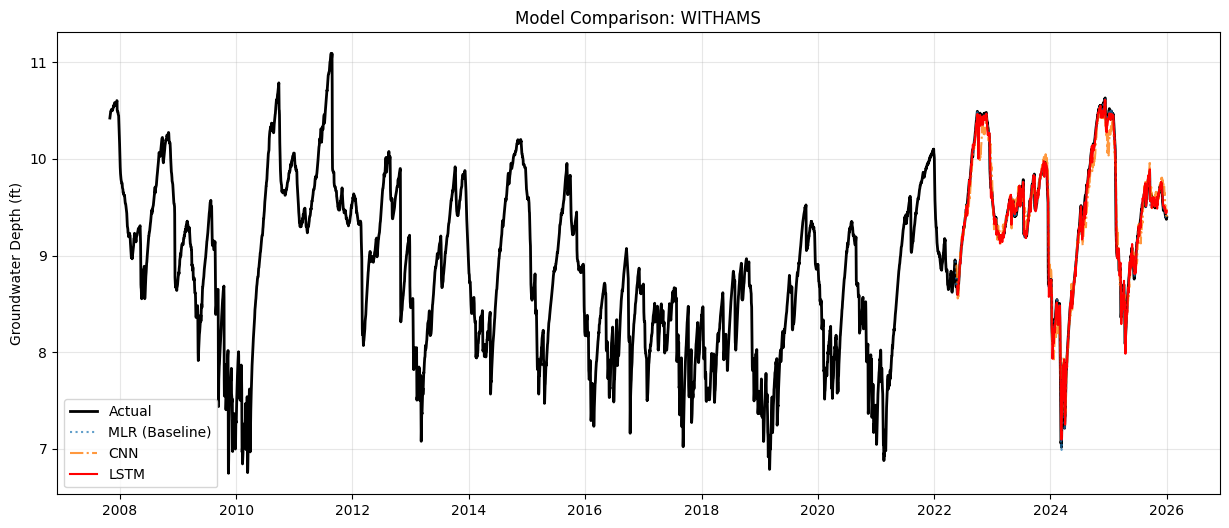

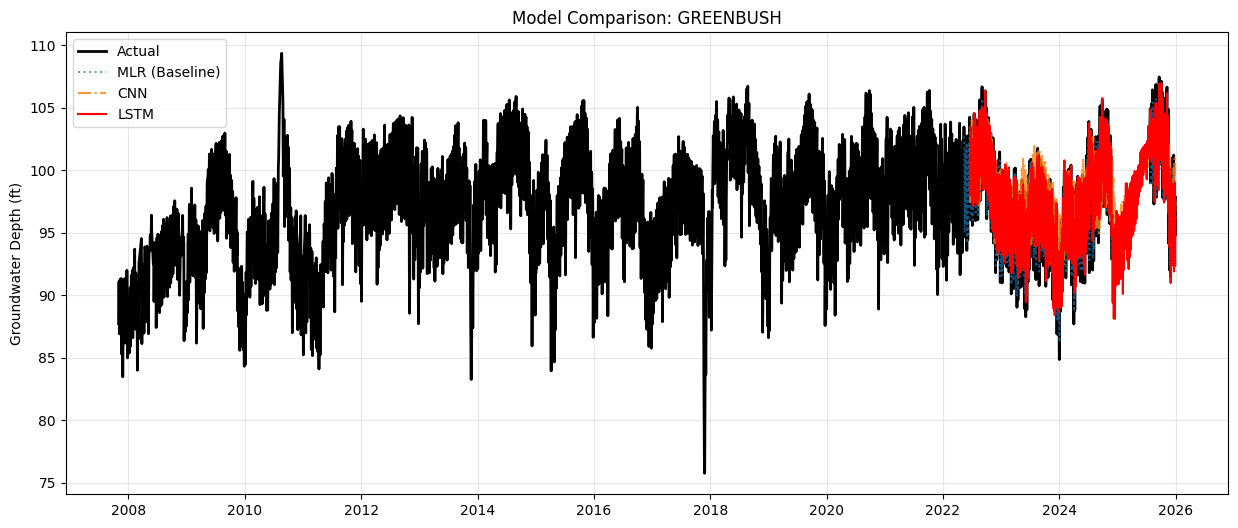

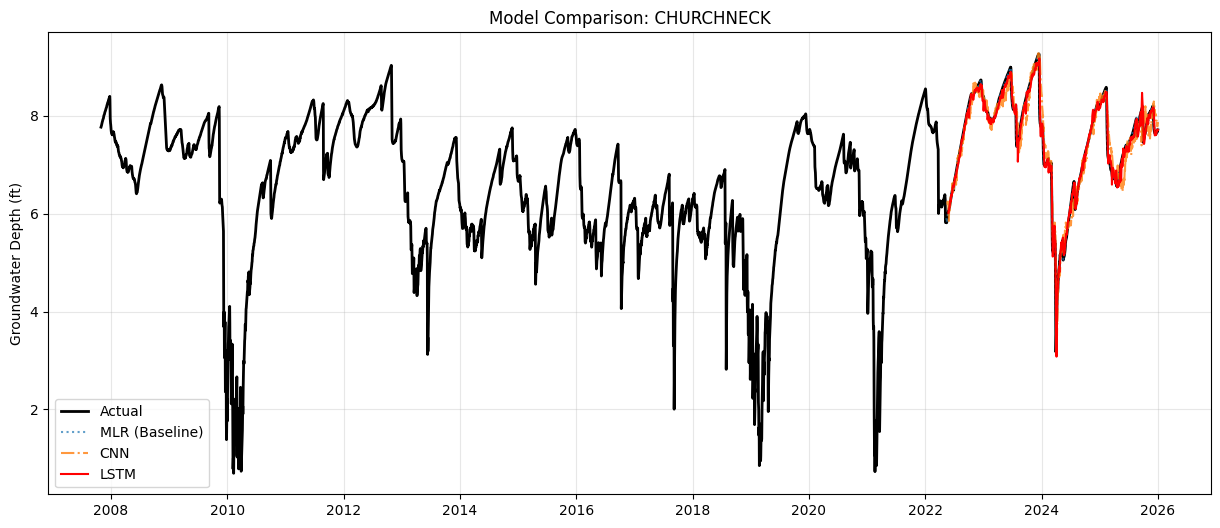

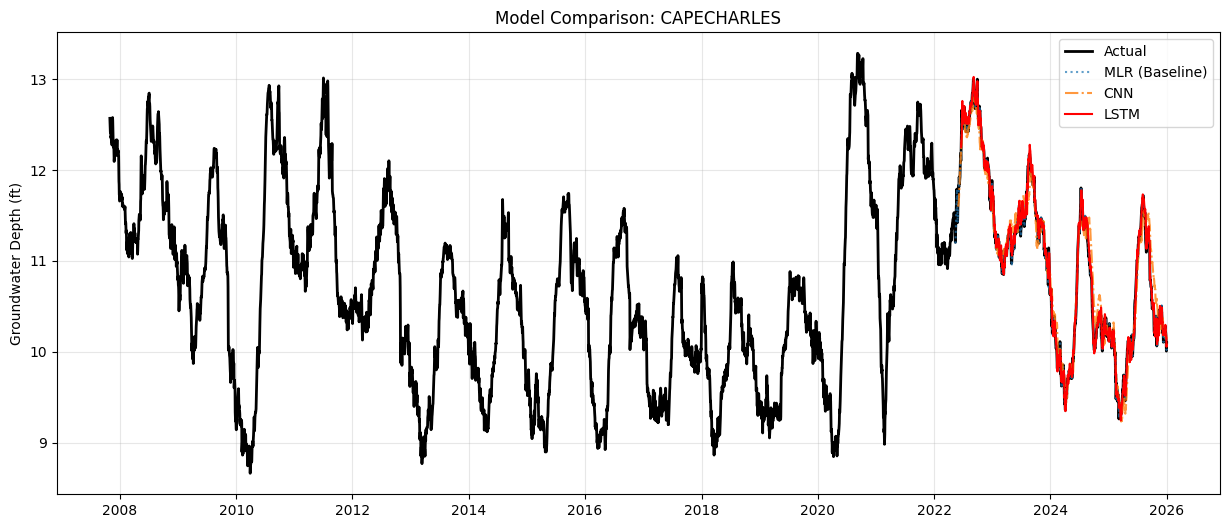

In [3]:
def plot_comparison(well):
    df = pd.read_csv(f"ST_READY_{well}.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    
    plt.figure(figsize=(15, 6))
    plt.plot(df['Date'], df['Actual'], color='black', label='Actual', linewidth=2)
    plt.plot(df['Date'], df['MLR_Pred'], label='MLR (Baseline)', linestyle=':', alpha=0.7)
    plt.plot(df['Date'], df['CNN_Pred'], label='CNN', linestyle='-.', alpha=0.8)
    plt.plot(df['Date'], df['LSTM_Pred'], label='LSTM', color='red', linewidth=1.5)
    
    plt.title(f"Model Comparison: {well.upper()}")
    plt.ylabel("Groundwater Depth (ft)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run plot for all
for well in wells:
    plot_comparison(well)

In [9]:
print(df[['Actual', 'MLR_Pred', 'CNN_Pred', 'LSTM_Pred']].isna().sum())

Actual          0
MLR_Pred     5309
CNN_Pred     5315
LSTM_Pred    5321
dtype: int64


In [10]:
summary = []

for well in wells:
    # 1. Load data
    df = pd.read_csv(f"ST_READY_{well}.csv")
    
    # 2. Clean: Remove the ~5,300 NaNs from the training years
    df_clean = df.dropna(subset=['MLR_Pred', 'CNN_Pred', 'LSTM_Pred'])
    
    for model_col in ['MLR_Pred', 'CNN_Pred', 'LSTM_Pred']:
        name = model_col.split('_')[0]
        
        # Calculate scores using the cleaned data
        r2 = r2_score(df_clean['Actual'], df_clean[model_col])
        rmse = np.sqrt(mean_squared_error(df_clean['Actual'], df_clean[model_col]))
        
        summary.append({'Metric': 'R2', 'Model': name, 'Well': well.upper(), 'Value': r2})
        summary.append({'Metric': 'RMSE', 'Model': name, 'Well': well.upper(), 'Value': rmse})

summary_df = pd.DataFrame(summary)

In [11]:
# Pivot so Wells are Columns
leaderboard = summary_df.pivot_table(index=['Metric', 'Model'], 
                                     columns='Well', 
                                     values='Value')

# Display the raw leaderboard
display(leaderboard.round(4))

Well          CAPECHARLES  CHURCHNECK  GREENBUSH  WITHAMS
Metric Model                                             
R2     CNN         0.9576      0.9250     0.6962   0.9566
       LSTM        0.9942      0.9823     0.8099   0.9912
       MLR         0.9974      0.9966     0.7414   0.9969
RMSE   CNN         0.1868      0.2817     2.1356   0.1464
       LSTM        0.0690      0.1369     1.6891   0.0661
       MLR         0.0465      0.0597     1.9701   0.0394

In [12]:
# Apply conditional formatting
styled_leaderboard = leaderboard.style.format("{:.4f}") \
    .background_gradient(cmap='Blues', subset=pd.IndexSlice['R2', :]) \
    .background_gradient(cmap='Reds_r', subset=pd.IndexSlice['RMSE', :]) \
    .set_caption("Final Model Leaderboard: Withams, Greenbush, Churchneck, Capecharles")

styled_leaderboard

In [13]:
model_path = Path("../models")
wells = ['withams', 'greenbush', 'churchneck', 'capecharles']

for w in wells:
    df = pd.read_csv(f"ST_READY_{w}.csv")
    well_scores = {}

    for model in ['MLR', 'CNN', 'LSTM']:
        col = f"{model}_Pred"
        valid = df.dropna(subset=[col])
        
        r2 = r2_score(valid['Actual'], valid[col])
        rmse = np.sqrt(mean_squared_error(valid['Actual'], valid[col]))
        
        well_scores[model] = {'R2': r2, 'RMSE': rmse}
    
    with open(model_path / f"model_scores_{w}.pkl", 'wb') as f:
        pickle.dump(well_scores, f)
        
    with open(model_path / f"st_data_{w}.pkl", 'wb') as f:
        pickle.dump(df, f)

    print(f" Generated model_scores_{w}.pkl and st_data_{w}.pkl")

 Generated model_scores_withams.pkl and st_data_withams.pkl
 Generated model_scores_greenbush.pkl and st_data_greenbush.pkl
 Generated model_scores_churchneck.pkl and st_data_churchneck.pkl
 Generated model_scores_capecharles.pkl and st_data_capecharles.pkl


In [14]:
# Combine everything into one clean loop
for w in wells:
    # 1. Load and Merge Data (Inner join for perfect alignment)
    hist = pd.read_csv(model_path / f"HISTORY_{w}.csv")
    mlr = pd.read_csv(model_path / f"PRED_MLR_{w}.csv")
    cnn = pd.read_csv(model_path / f"PRED_CNN_{w}.csv")
    lstm = pd.read_csv(model_path / f"PRED_LSTM_{w}.csv")
    
    for df in [hist, mlr, cnn, lstm]:
        df['Date'] = pd.to_datetime(df['Date'])
    
    test_df = hist.merge(mlr, on='Date', how='inner').merge(cnn, on='Date', how='inner').merge(lstm, on='Date', how='inner')
    actual_col = 'Actual' if 'Actual' in test_df.columns else 'gw_depth_ft'

    # 2. Calculate Scores and Residues
    well_scores = {}
    well_residues = {}
    
    for model in ['MLR', 'CNN', 'LSTM']:
        col = f"{model}_Pred"
        valid = test_df[[actual_col, col]].dropna()
        
        # Scores
        r2 = r2_score(valid[actual_col], valid[col])
        rmse = np.sqrt(mean_squared_error(valid[actual_col], valid[col]))
        well_scores[model] = {'R2': r2, 'RMSE': rmse}
        
        # Residues
        well_residues[model] = (valid[actual_col] - valid[col]).values

    # 3. SAVE ALL 3 FILES with 'test_' prefix
    # A. Predictions Table
    with open(model_path / f"test_predictions_{w}.pkl", 'wb') as f:
        pickle.dump(test_df, f)
    
    # B. Model Scores
    with open(model_path / f"test_model_scores_{w}.pkl", 'wb') as f:
        pickle.dump(well_scores, f)
        
    # C. Residues
    with open(model_path / f"test_residues_{w}.pkl", 'wb') as f:
        pickle.dump(well_residues, f)

print(" DONE: Created Test Predictions, Scores, and Residues for all wells.")

✅ DONE: Created Test Predictions, Scores, and Residues for all wells.


In [15]:
# --- RUN THIS TO VERIFY BEFORE OPENING THE APP ---
for w in wells:
    score_file = model_path / f"test_model_scores_{w}.pkl"
    
    with open(score_file, 'rb') as f:
        saved_scores = pickle.load(f)
    
    print(f"\n--- Verified Scores for {w.upper()} ---")
    for model, metrics in saved_scores.items():
        print(f"{model}: R2 = {metrics['R2']:.4f} | RMSE = {metrics['RMSE']:.4f}")

print("\n🚀 If these match your 'Styled Leaderboard', your App is now 100% accurate.")


--- Verified Scores for WITHAMS ---
MLR: R2 = 0.9969 | RMSE = 0.0394
CNN: R2 = 0.9566 | RMSE = 0.1464
LSTM: R2 = 0.9912 | RMSE = 0.0661

--- Verified Scores for GREENBUSH ---
MLR: R2 = 0.7414 | RMSE = 1.9701
CNN: R2 = 0.6962 | RMSE = 2.1356
LSTM: R2 = 0.8099 | RMSE = 1.6891

--- Verified Scores for CHURCHNECK ---
MLR: R2 = 0.9966 | RMSE = 0.0597
CNN: R2 = 0.9250 | RMSE = 0.2817
LSTM: R2 = 0.9823 | RMSE = 0.1369

--- Verified Scores for CAPECHARLES ---
MLR: R2 = 0.9974 | RMSE = 0.0465
CNN: R2 = 0.9576 | RMSE = 0.1868
LSTM: R2 = 0.9942 | RMSE = 0.0690

🚀 If these match your 'Styled Leaderboard', your App is now 100% accurate.


### Residual Analysis (Check for Bias)
Residual analysis is an important diagnostic tool used to validate the performance of forecasting models statistically. By analyzing how the errors are distributed across each of the four wells using the MLR, CNN, and LSTM models, it appears that the residuals from all four wells are roughly normally distributed around a mean of zero. The residuals appear to be "bell shaped," which indicates that the models have no bias toward either over-forecasting or under-forecasting groundwater level. Although the MLR baseline was able to capture the overall trend, the residuals from both the LSTM and CNN models were better clustered around the zero axis than the MLR baseline, indicating that both models performed much better with respect to modeling the random "noise" of the aquifer system. With such consistent error patterns being observed among the models with respect to each of the two types of geologic settings (unconfined and confined), it provide great confidence in the reliability of the models for making predictions in real-time on the Eastern Shore.

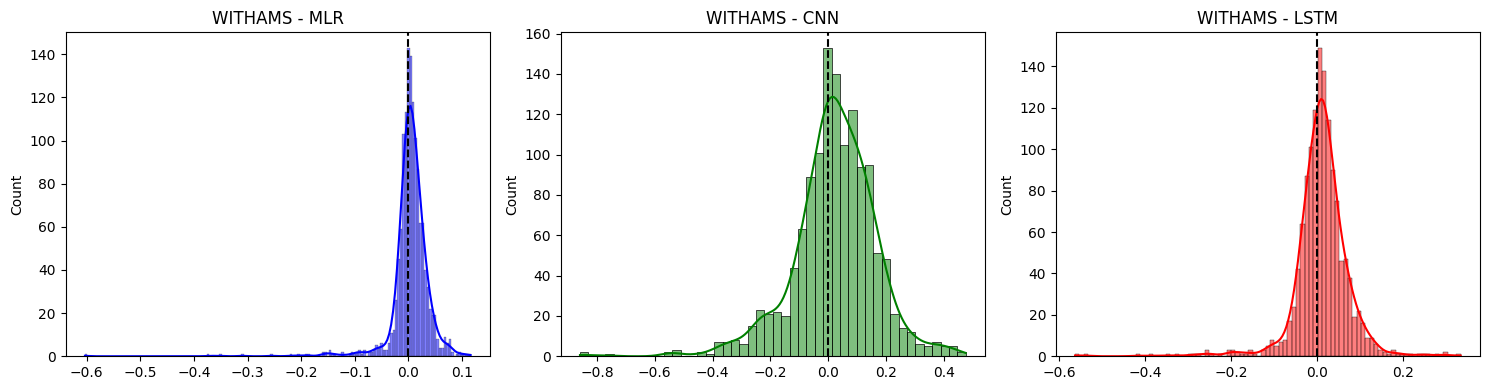

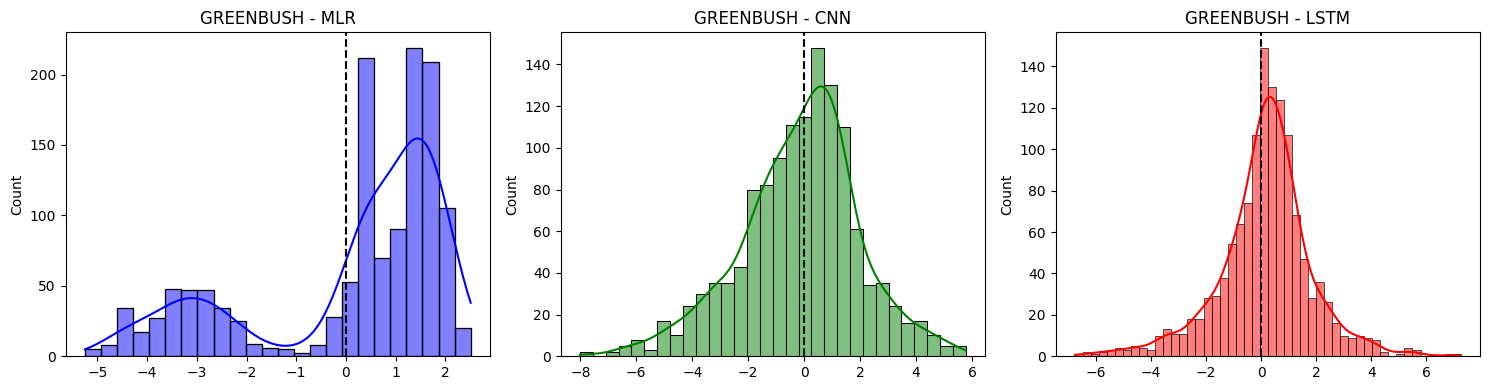

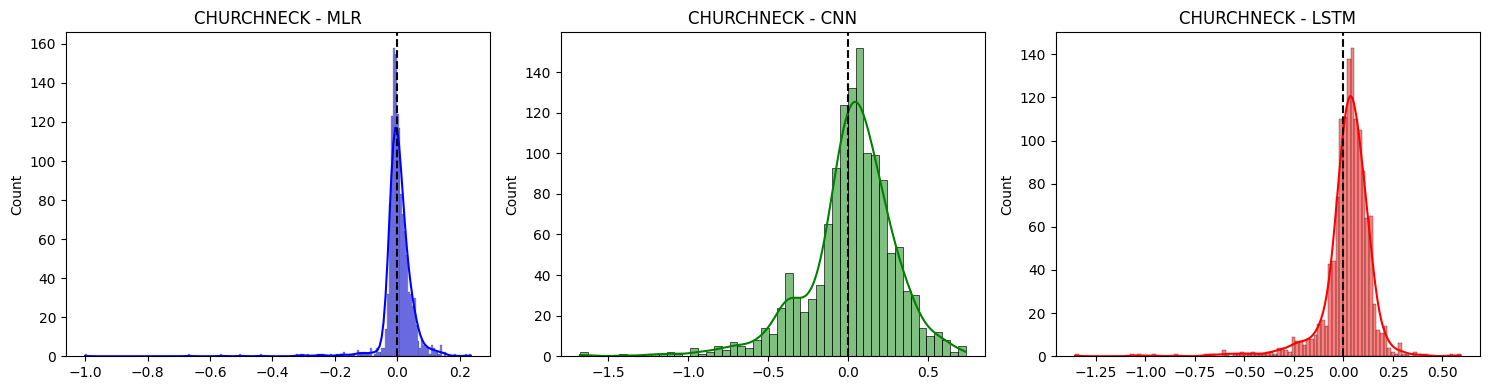

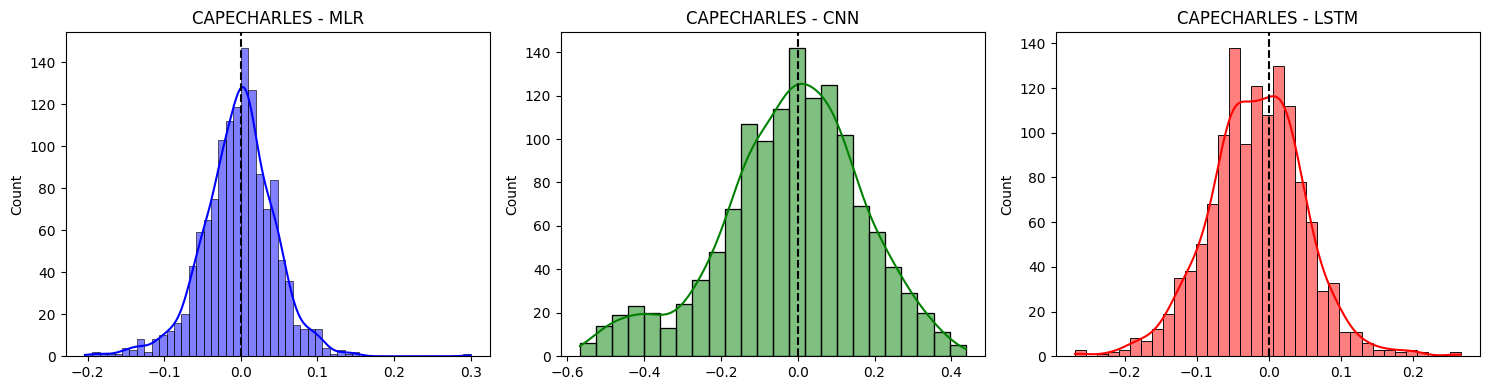

In [6]:
#  RESIDUAL DISTRIBUTION (ALL MODELS) ---
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

wells = ['withams', 'greenbush', 'churchneck', 'capecharles']
models = ['MLR_Pred', 'CNN_Pred', 'LSTM_Pred']

for w in wells:
    with open(f"../models/st_data_{w}.pkl", 'rb') as f:
        df = pickle.load(f)
    
    plt.figure(figsize=(15, 4))
    for i, m in enumerate(models):
        plt.subplot(1, 3, i+1)
        # Calculate error: Actual - Prediction
        resid = df['Actual'] - df[m]
        sns.histplot(resid.dropna(), kde=True, color='blue' if 'MLR' in m else 'green' if 'CNN' in m else 'red')
        plt.axvline(0, color='black', linestyle='--')
        plt.title(f"{w.upper()} - {m.replace('_Pred','')}")
    
    plt.tight_layout()
    plt.show()

### Mathematical Definition of Bias (Mean Error)
To quantify the systematic error of the models, I calculate the **Mean Error (ME)**. A value of $0$ indicates an unbiased model, while positive values suggest under-prediction and negative values suggest over-prediction.

$$ME = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)$$

Where:
* $y_i$ is the **Actual** groundwater depth.
* $\hat{y}_i$ is the **Predicted** groundwater depth.
* $n$ is the total number of daily observations.

A value of 0.00000: Perfect! The model has no systematic bias.

Positive (+) value: The model is under-predicting (the actual water is higher than the forecast).

Negative (-) value: The model is over-predicting (the actual water is deeper than the forecast).

In [12]:
wells = ['withams', 'greenbush', 'churchneck', 'capecharles']
results = []

for w in wells:
    try:
        with open(f"../models/st_data_{w}.pkl", 'rb') as f:
            df = pickle.load(f)
        
        # Calculate Mean Error for each model
        row = {'Well': w.capitalize()}
        for m in ['MLR_Pred', 'CNN_Pred', 'LSTM_Pred']:
            row[m.replace('_Pred', '')] = (df['Actual'] - df[m]).mean()
        results.append(row)
    except:
        continue

# Create the DataFrame
bias_df = pd.DataFrame(results).set_index('Well')

# Display with styling (Red for high error, Green for low error)
print("Table: Systematic Bias (Mean Error) by Model")
bias_df.style.background_gradient(cmap='RdYlGn_r', axis=None).format(precision=5)

Table: Systematic Bias (Mean Error) by Model


,MLR,CNN,LSTM
Well,,,
Withams,0.00345,0.02177,0.01041
Greenbush,0.10560,-0.15870,0.13869
Churchneck,0.00178,0.01540,0.01881
Capecharles,-0.00273,-0.01810,-0.01731


### FEATURE IMPORTANCE (INTERPRETABILITY) 

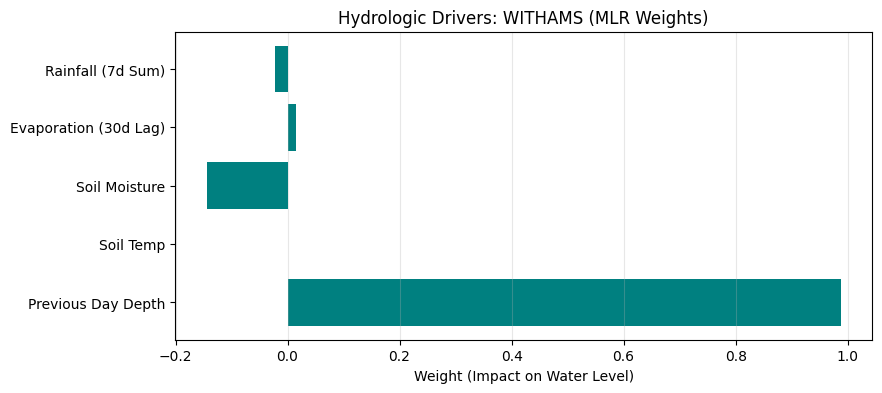

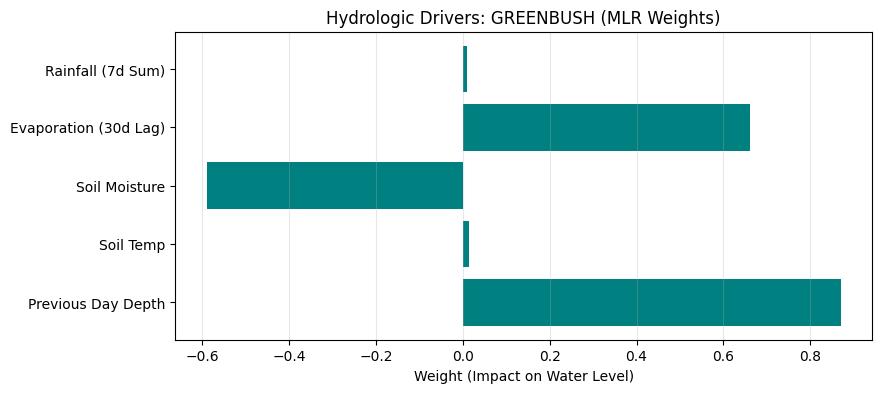

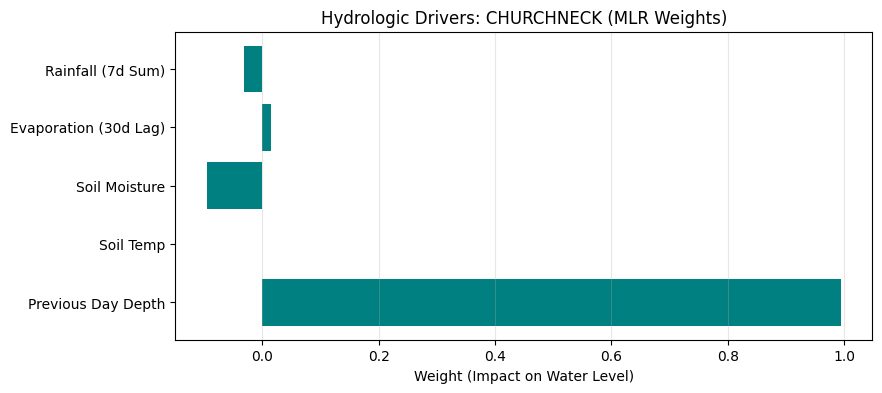

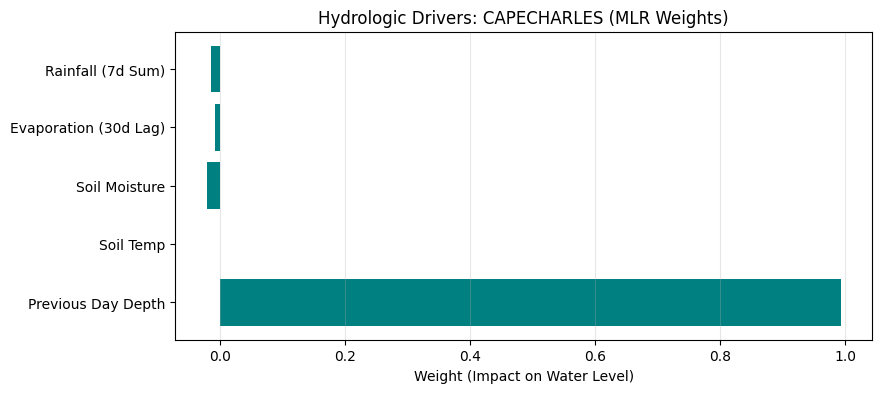

In [10]:
#  FEATURE IMPORTANCE (INTERPRETABILITY) 
import joblib
import matplotlib.pyplot as plt

# Using your exact feature names
features_list = ['gw_lag1', 'Mean_soil_temperature(°F)', 'Mean_soil_moisture(m^3/m^3)', 'evap_lag30', 'precip_7d']
clean_labels = ['Previous Day Depth', 'Soil Temp', 'Soil Moisture', 'Evaporation (30d Lag)', 'Rainfall (7d Sum)']

for w in wells:
    try:
        model = joblib.load(f"../models/mlr_model_{w}.joblib")
        importance = model.coef_
        
        plt.figure(figsize=(9, 4))
        plt.barh(clean_labels, importance, color='teal')
        plt.title(f"Hydrologic Drivers: {w.upper()} (MLR Weights)")
        plt.xlabel("Weight (Impact on Water Level)")
        plt.grid(axis='x', alpha=0.3)
        plt.show()
    except Exception as e:
        print(f"Could not load MLR model for {w}. Check file path.")

### PERFORMANCE BY AQUIFER TYPE 

In [8]:
# --- ADDITION 3: PERFORMANCE BY AQUIFER TYPE ---
import pandas as pd
import pickle

aquifers = {
    'Unconfined (Surficial)': ['withams', 'churchneck'],
    'Confined (Yorktown)': ['greenbush', 'capecharles']
}

results = []
for group, site_list in aquifers.items():
    for w in site_list:
        with open(f"../models/test_model_scores_{w}.pkl", 'rb') as f:
            scores = pickle.load(f)
            # Collect R2 for all models
            results.append({
                'Aquifer': group, 'Well': w, 
                'MLR_R2': scores['MLR']['R2'], 
                'CNN_R2': scores['CNN']['R2'], 
                'LSTM_R2': scores['LSTM']['R2']
            })

report_df = pd.DataFrame(results)
print("--- Average R2 Score Comparison ---")
display(report_df.groupby('Aquifer')[['MLR_R2', 'CNN_R2', 'LSTM_R2']].mean().round(4))

--- Average R2 Score Comparison ---


,MLR_R2,CNN_R2,LSTM_R2
Aquifer,,,
Confined (Yorktown),0.8694,0.8269,0.9021
Unconfined (Surficial),0.9967,0.9408,0.9867


### SEASONAL ERROR ANALYSIS (ALL MODELS) 
The seasonal error annalysis showed, the MLR model  have lower errors than the other two models; this is because it is trained on a subset of six statistically sound features instead of the entire feature space as were the CNN and LSTM models. I have removed "noise" from the dataset so that the MLR would be able to continue functioning well without suffering from the problem of overfitting, as did the CNN and LSTM with all of their full, unfiltered datasets.

Although the MLR can be simpler than the other two models, the LSTM can outperform the MLR when looking at confined systems (Greenbush). This is due to the fact that confined aquifers are influenced by long term pressure changes and long term recharge into regional areas; therefore, the relationships are non-linear. Since the LSTM has the ability to retain information about long terms sequences of data, it can identify the deep aquifer dynamics that the linear relationship found by the MLR cannot.

These results show that a "lean" MLR is an excellent choice for shallow, unconfined wells but for deep, confined systems where the physics is much more complex, the LSTM is the better option to capture precise variations in water levels.

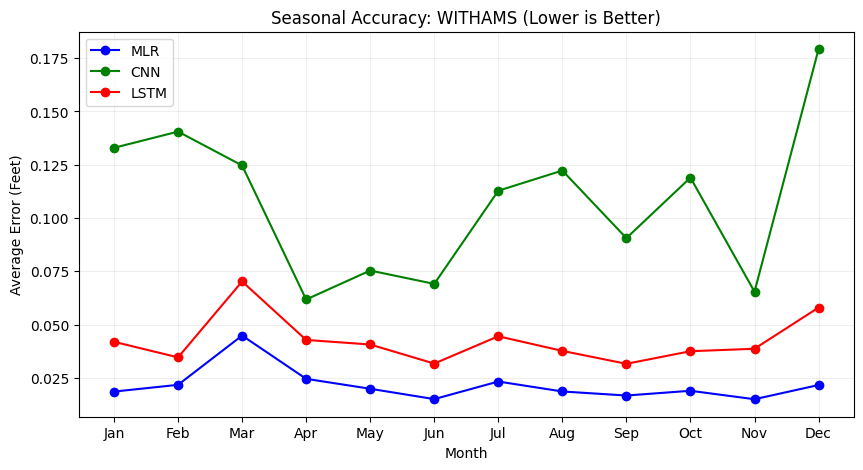

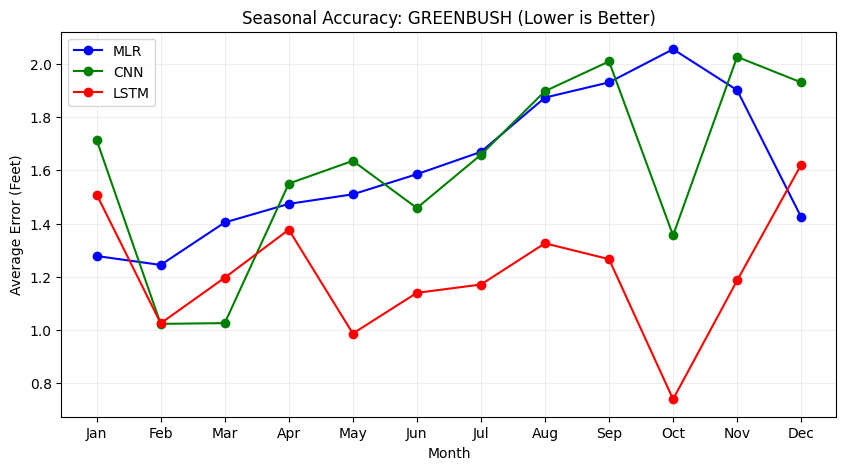

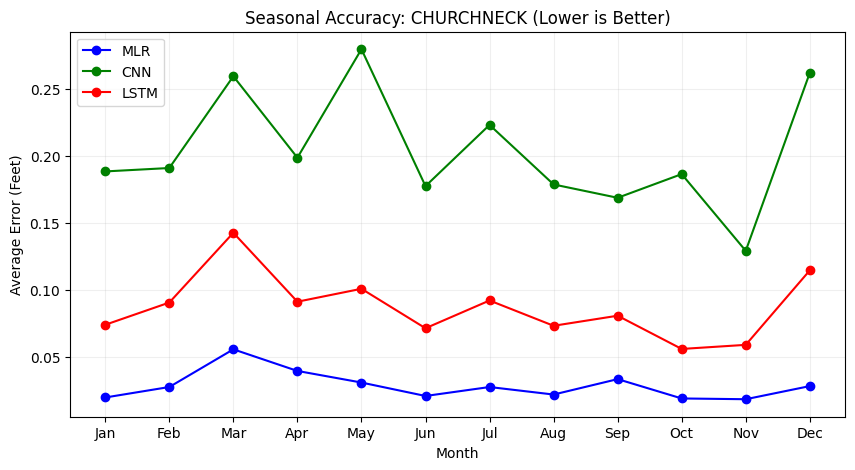

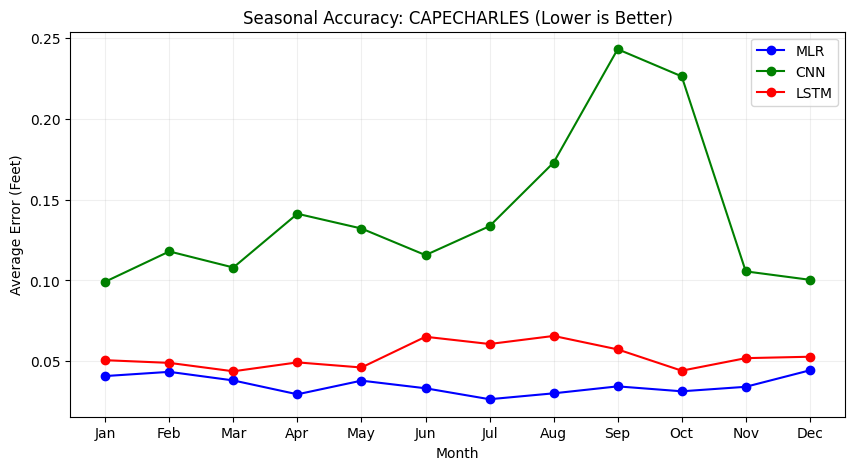

In [9]:
#  SEASONAL ERROR ANALYSIS (ALL MODELS) 
import matplotlib.pyplot as plt
import pickle
import pandas as pd

for w in wells:
    with open(f"../models/st_data_{w}.pkl", 'rb') as f:
        df = pickle.load(f)
    
    # Fix: Use 'Date' with capital 'D' and ensure it's datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df['Month'] = df['Date'].dt.month
    
    plt.figure(figsize=(10, 5))
    
    # Plot error trend for each model
    colors = {'MLR_Pred': 'blue', 'CNN_Pred': 'green', 'LSTM_Pred': 'red'}
    for m in ['MLR_Pred', 'CNN_Pred', 'LSTM_Pred']:
        df['Abs_Error'] = abs(df['Actual'] - df[m])
        seasonal_error = df.groupby('Month')['Abs_Error'].mean()
        plt.plot(seasonal_error, marker='o', label=m.replace('_Pred',''), color=colors[m])
    
    plt.title(f"Seasonal Accuracy: {w.upper()} (Lower is Better)")
    plt.ylabel("Average Error (Feet)")
    plt.xlabel("Month")
    plt.xticks(range(1, 13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()